In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT

from my_utils import *

def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(  np.dot(deviations**2,weights)   )
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(  sum(deviations**2) /len(x)  )
def list_mean(x):
  mean = sum(x)/len(x)
  return mean

Welcome to JupyROOT 6.14/04


['0110', '0009']
0 ------------> peaking time =  10 , gain =  1
1 . scan 
 parallel baseline scan, all channels same baseline set at a step


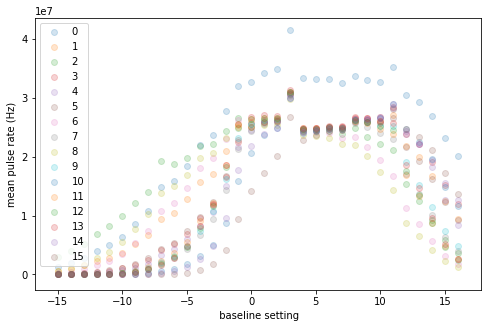

0110 average(16chan) noise thresh: mean =  4.807  +-  1.591   |  RMS  =  5.733  +-  0.69
1 ------------> peaking time =  10 , gain =  1
2 . scan 
 individual baseline scan, inactive = -15 


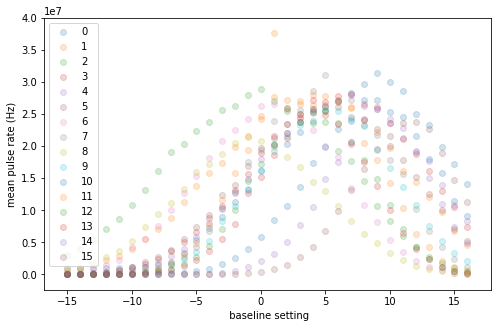

0110 average(16chan) noise thresh: mean =  4.583  +-  2.987   |  RMS  =  4.995  +-  0.87
2 ------------> peaking time =  10 , gain =  1
3 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[6.0, 6.0, 6.0, 7.0, 6.0, 8.0, 7.0, 6.0, 3.0, 1.0, 3.0, 2.0, 2.0, 3.0, 4.0, 3.0]


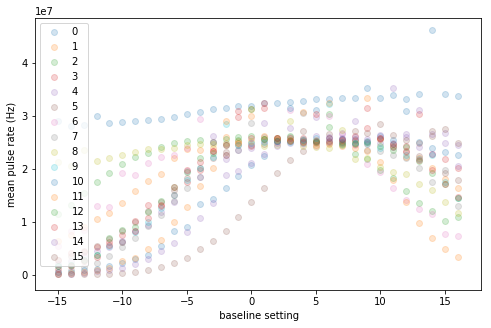

0110 average(16chan) noise thresh: mean =  3.287  +-  2.07   |  RMS  =  7.312  +-  0.928
0 ------------> peaking time =  10 , gain =  1
4 . scan 
 parallel baseline scan, all channels same baseline set at a step


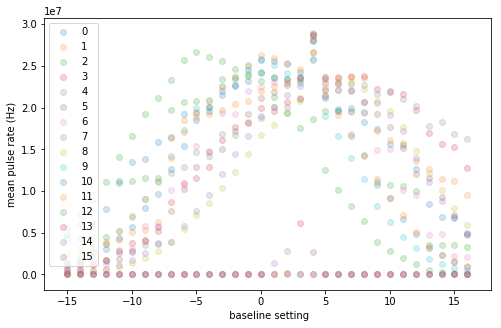

0009 average(16chan) noise thresh: mean =  2.153  +-  2.091   |  RMS  =  5.221  +-  2.427
1 ------------> peaking time =  10 , gain =  1
5 . scan 
 individual baseline scan, inactive = -15 


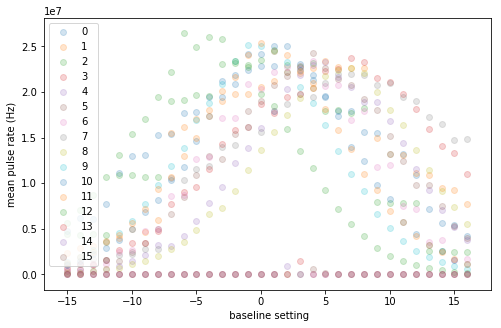

0009 average(16chan) noise thresh: mean =  2.134  +-  2.28   |  RMS  =  5.149  +-  2.377
2 ------------> peaking time =  10 , gain =  1
6 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[1.0, 5.0, -1.0, 7.0, 5.0, 4.0, 3.0, 7.0, 6.0, -0.0, 1.0, 0.0, -4.0, 3.0, 2.0, 4.0]


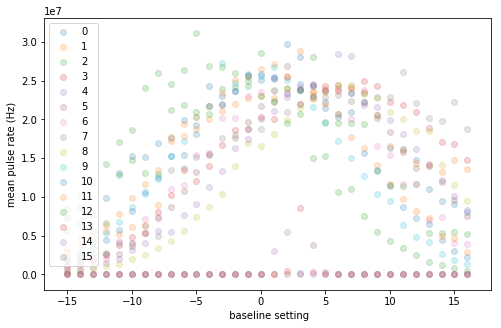

0009 average(16chan) noise thresh: mean =  2.158  +-  2.098   |  RMS  =  5.579  +-  2.545


>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [2]:
## scan threshold of all boar
from functools import (reduce)
from math import (sqrt)
import numpy as np
import time
import tdc_daq as td
import matplotlib.pyplot as plt
import db



# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)

#ptime_list = [ 10, 15, 20 ]
ptime_list = [ 10 ]
# pt_gain_list = [ 1, 2, 4 ]
pt_gain_list = [1]  

for my_board in db.board_list():
  db.set_standby_board(my_board) #name = "0029" #PASSTEC board id (inside )

# used_boards = [ "0021"]
used_boards = [ "0110",  "0009"  ]
# used_boards = ["0009", "0011" ,"0108", "0102", "0103" ]
#used_boards = ["0002"]
#used_boards = db.board_list_installed()
# used_boards = used_boards[0:10]
# used_boards = used_boards[10:30]
print(used_boards)
nscans = 3
n_scan_steps = len(ptime_list)*len(pt_gain_list)*nscans

plt.rcParams["figure.figsize"] = (8,5)
trendtime_list = []
rmsAverageTrend_list = []
rmsAverageTrendError_list = []
meanAverageTrend_list = []
meanAverageTrendError_list = []

mean_scans = [[[] for b in range(len(used_boards)) ]  for i in range(n_scan_steps) ]
rms_scans =  [[[] for b in range(len(used_boards)) ]  for i in range(n_scan_steps) ]

scaler_list_channel = [[[] for i in range(n_scan_steps) ]  for i in range(16)] 
   




for ptime in ptime_list: 
 for pt_gain in pt_gain_list: 
  b = -1    
  for name in used_boards: 
   b += 1        
   scan_step = -1
   for scan in range(0,nscans): 
    scan_step += 1 
    print(scan_step,"------------> peaking time = ", ptime, ", gain = ", pt_gain)

   

    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
    # pause for not killing trb by sending to many parallel commands regiser writes:
    time.sleep(5) 
    trendtime_list += [ name ]
    ptc.init_boards_by_name(used_boards, ptime, pt_gain)   
    print(len(trendtime_list),". scan ")
    #### baseline scan, all channels in parallel (same baseline set to all channels at once):
    if scan == 0:
        print(" parallel baseline scan, all channels same baseline set at a step")        
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True) 
    #### baseline scan each channel individual, while other channels are "inactive", = baseline is minimal -15 or (maximal +15)
    if scan == 1:
        print(" individual baseline scan, inactive = -15 ")
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
    if scan == 2:
        print(" individual baseline scan, all other channesl active  baseline = calibrated individual baseline")
        bl_values = [0]*16
        ## get the baselines calibrated for all 16 channels from database:
        calib = db.get_calib_json_by_name(name)
        if ("baselines" in calib):
            board_baselines = calib["baselines"]
            bl_values   = board_baselines[0:17]   
        print(bl_values)
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True,baseline_inactive=bl_values)
#     calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
#     board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["noise_scan_raw"]
    tsbl_range    = dummy_calib["bl_range"]

#     scaler_list = []
#     scaler_list = td.scaler_rate_of_board(name,0.2)
    

    for i in range(0,16):
     plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("  baseline setting ")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()


    fwhm_list = []
    max_list  = []
    rms_list = []
    mean_list = []
    for i in range(0,16):
      fwhm_list += [ fwhm(tsbl_range,tsbl_scan_raw[i]) ]
      rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
      mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  
      max_list  += [ np.max(tsbl_scan_raw[i])  ]
      scaler_list_channel[i][scan_step] = tsbl_scan_raw[i] 
    mean_scans[scan][b] = mean_list
    rms_scans[scan][b]  = rms_list    
    fwhm_list = np.array(fwhm_list)
    max_list  = np.array(max_list)
    
    print(name, "average(16chan) noise thresh: mean = ", round(sum(mean_list)/len(mean_list),3), " +- ", round(list_rms(mean_list),3), "  |  RMS  = ", round(sum(rms_list)/len(rms_list),3), " +- ", round(list_rms(rms_list),3) )

    meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
    meanAverageTrendError_list += [ list_rms(mean_list) ]
    rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
    rmsAverageTrendError_list += [ list_rms(rms_list) ]    
    



0110


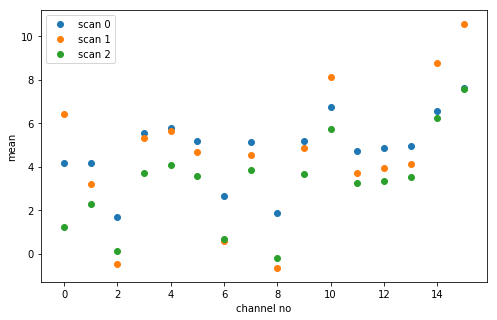

0009


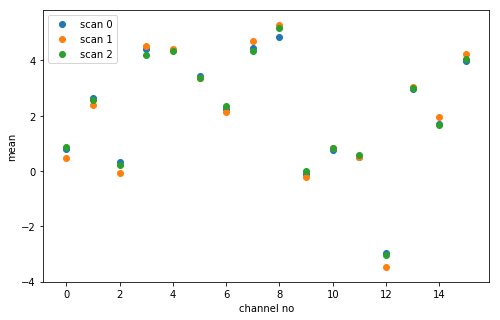

0110


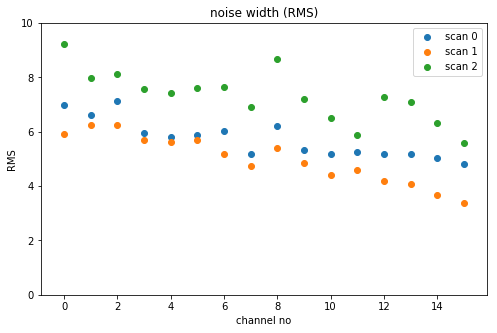

0009


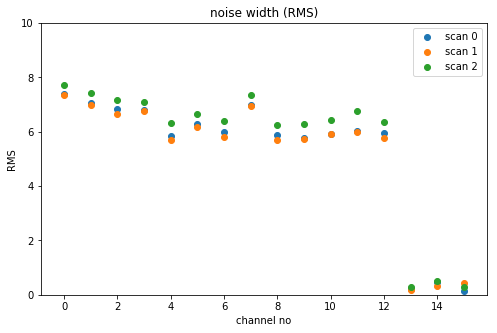

channel :  0


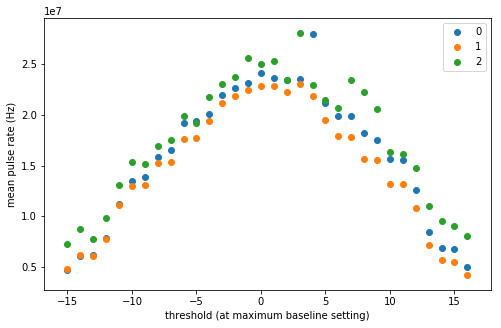

channel :  1


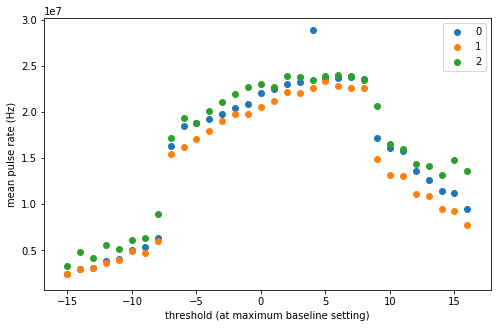

channel :  2


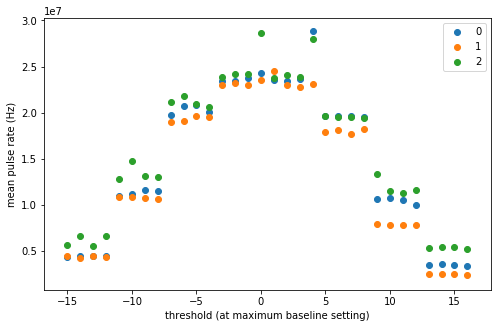

channel :  3


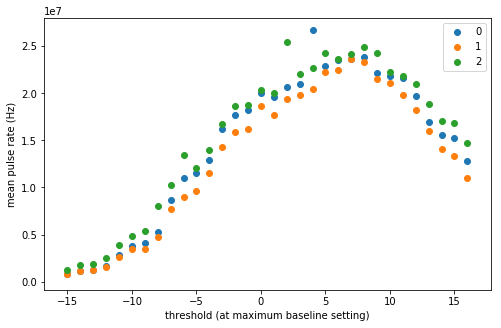

channel :  4


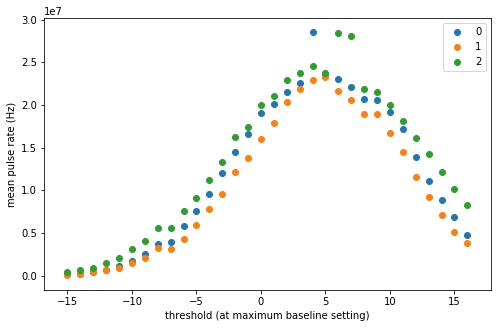

channel :  5


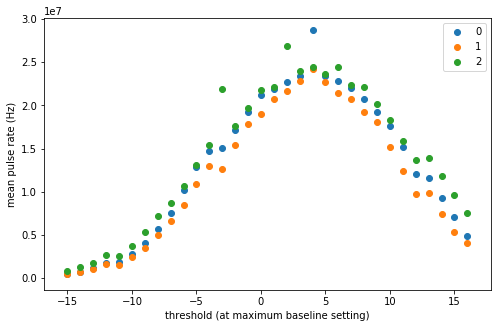

channel :  6


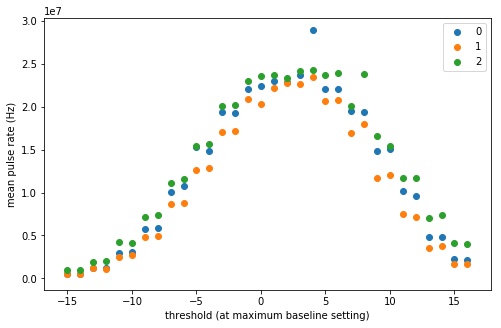

channel :  7


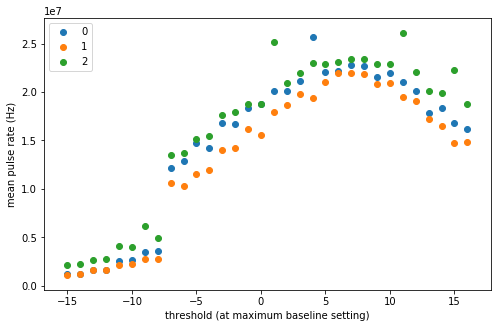

channel :  8


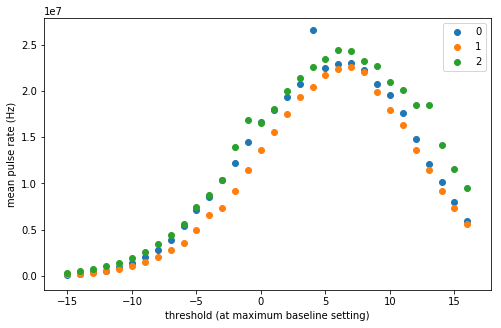

channel :  9


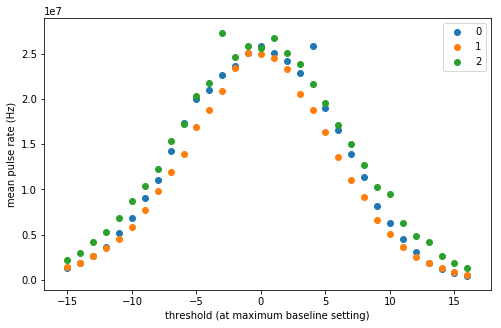

channel :  10


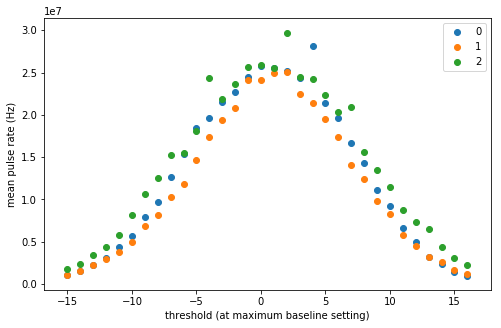

channel :  11


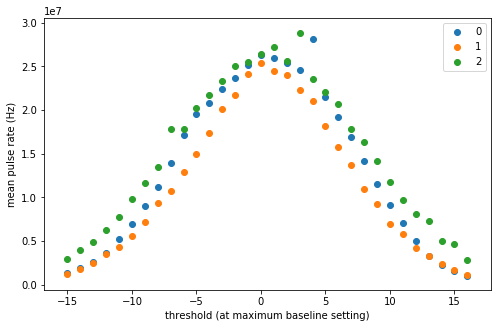

channel :  12


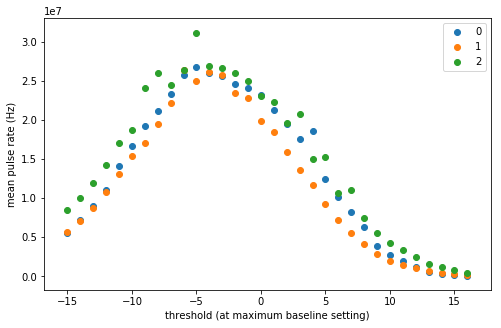

channel :  13


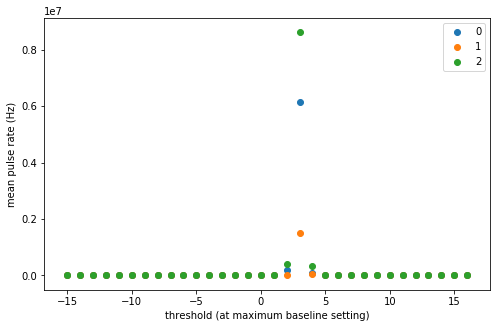

channel :  14


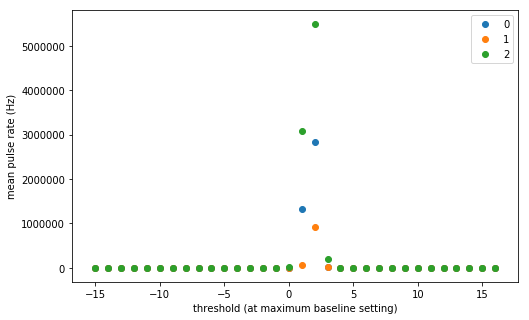

channel :  15


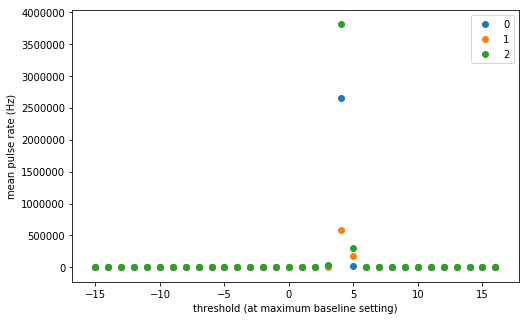

In [3]:
for i in range(len(used_boards)):
 print(used_boards[i])
 for scan in range(0,nscans): 
    plt.scatter(list(range(0,len(mean_scans[scan][i]))), mean_scans[scan][i],label = "scan {:d}".format(scan))
    plt.xlabel("channel no")
    plt.ylabel("mean")
 plt.legend()
 plt.show()
for i in range(len(used_boards)):
 print(used_boards[i])
 for scan in range(0,nscans): 
#     plt.scatter(list(range(0,len(mean_scans[scan]))),rms_scans[scan],color='blue',label = "scan {:d}".format(scan))
    plt.scatter(list(range(0,len(mean_scans[scan][i]))),rms_scans[scan][i], label = "scan {:d}".format(scan))  
    plt.xlabel("channel no")
    plt.ylabel("RMS")
    plt.ylim(ymax = 10, ymin = 0)
    plt.title("noise width (RMS)")
 plt.legend()
 plt.show()

for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     plt.scatter(tsbl_range,scaler_list_channel[ch][i],label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()


In [4]:
#archive(label="baseline_individual_scan_board0021_4xLVDS-Ferrites")

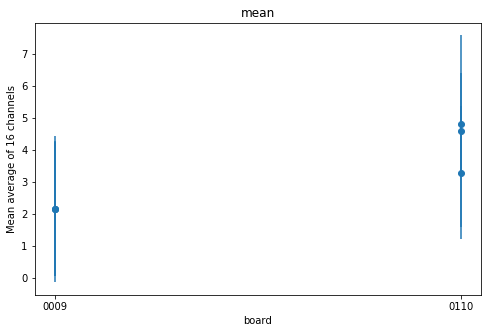

No handles with labels found to put in legend.


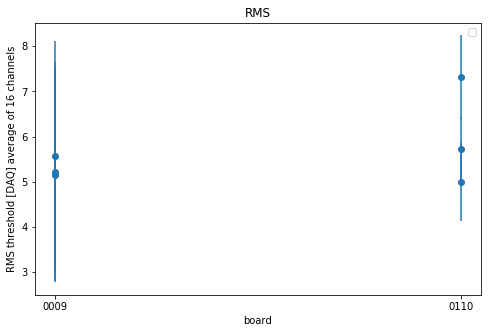

Mean (of all boards) =  3.18707645582  +-  1.14158277508
RMS (of all boards) =  5.66468190187  +-  0.778437148416


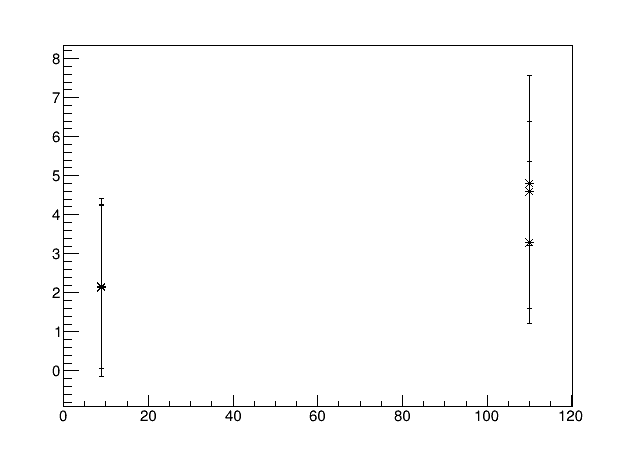

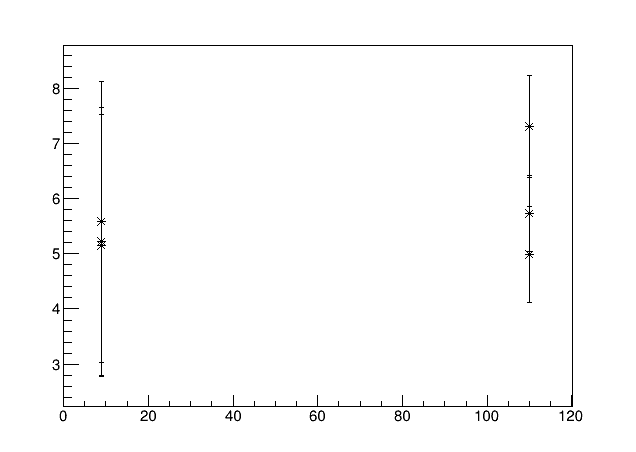

In [5]:
plt.errorbar(trendtime_list, meanAverageTrend_list, yerr=meanAverageTrendError_list, fmt='o')
#plt.scatter(trendtime_list, meanAverageTrend_list)
plt.xlabel("board")
plt.ylabel("Mean average of 16 channels")
plt.title("mean")
plt.show()
    
plt.errorbar(trendtime_list, rmsAverageTrend_list, yerr=rmsAverageTrendError_list, fmt='o')
plt.xlabel("board")
plt.ylabel("RMS threshold [DAQ] average of 16 channels")
plt.title("RMS")
plt.legend()
plt.show()

import ROOT


gr  = ROOT.TGraphErrors()
gr2 = ROOT.TGraphErrors()
#len(meanAverageTrend_list),np.array(trendtime_list),np.array(meanAverageTrend_list))
for i in range(0,len(meanAverageTrend_list)):
    gr.SetPoint(i, np.double(trendtime_list[i]), np.double(meanAverageTrend_list[i]))
    gr.SetPointError(i, 0, np.double(meanAverageTrendError_list[i]) )
    gr2.SetPoint(i, np.double(trendtime_list[i]), np.double(rmsAverageTrend_list[i]))
    gr2.SetPointError(i, 0, np.double(rmsAverageTrendError_list[i]) )    
c = ROOT.TCanvas("mean","mean",640,480)
gr.Draw("A*")
c.Draw()
c2 = ROOT.TCanvas("rms","rms",640,480)
gr2.Draw("A*")

c2.Draw()
print("Mean (of all boards) = ", list_mean(meanAverageTrend_list), " +- ", list_rms(meanAverageTrend_list) )
print("RMS (of all boards) = ", list_mean(rmsAverageTrend_list), " +- ", list_rms(rmsAverageTrend_list) )

#db.find_board_by_name("0030")

In [6]:
plt.rcParams["figure.figsize"] = (8,15)
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     nums = np.array(scaler_list_channel[ch][i])*10**(16-ch)
     plt.scatter(tsbl_range,nums,alpha=0.2,label = "{:d}".format(baseline[i]))

     #plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")

plt.yscale('log') 
plt.ylim(ymax = 1E24, ymin = 1E1)
plt.show()



channel :  0


NameError: name 'baseline' is not defined